In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random
from shapely.geometry import Point, Polygon
from skimage import feature
import os
import cvxopt
import cvxopt.solvers
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

# path = '/content/drive/MyDrive/Colab_Notebooks/ECSE415_Final_Project/' # Kun's path, comment out when needed
path = '/content/drive/MyDrive/Colab_Notebooks/ECSE415_Final_Project/' # Jay's path
# path = '/content/drive/My Drive/ECSE_415/Project/' # Ben's path
# path = './' # Kamy's path

Mounted at /content/drive


In [82]:
# Inspired from https://medium.com/@luanaebio/detecting-people-with-yolo-and-opencv-5c1f9bc6a810

images = []
path_frames = path + 'frames/'
detected_frames = []
positive_patches = []
negative_patches = []

# load images from frames/
for count,image_path in enumerate(os.listdir(path_frames)):
  if count > 30:
    break
  input_path = os.path.join(path_frames, image_path)
  image = plt.imread(input_path)
  images.append(image)

Width = image.shape[1]
Height = image.shape[0]

# load class names
classes = None
with open(path + 'coco.names', 'r') as f:
  classes = [line.strip() for line in f.readlines()]

# read pre-trained model and config file
net = cv2.dnn.readNet(path + 'yolov3.weights', path + 'cfg/yolov3.cfg')

for image in images:
  image_patches = image.copy()

  # create input blob 
  # set input blob for the network
  # blob = cv2.dnn.blobFromImage(image, scalefactor=?, size=?, mean substraction value=?, swapRB=?)
  blob = cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False)
  net.setInput(blob)

  # run inference through the network
  layer_names = net.getLayerNames()
  output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

  # gather predictions from output layers
  outs = net.forward(output_layers)

  # initiatialization
  class_ids = []
  confidences = []
  boxes = []
  conf_threshold = 0.5
  nms_threshold = 0.4
  boxes_positive_patches = []

  # for each detetion from each output layer get the confidence, class id, bounding box params and ignore weak detections (confidence < 0.5) 
  for out in outs:
    for detection in out:
      scores = detection[5:] # from 0-4, is matched box coordinates/dimension info, from 5 onwards is an array of confidence scores towards each different class in classes
      class_id = np.argmax(scores) # return the index of max confidence
      confidence = scores[class_id] # get the confidence score
      if confidence > conf_threshold:
        center_x = int(detection[0] * Width)
        center_y = int(detection[1] * Height)
        w = int(detection[2] * Width)
        h = int(detection[3] * Height)
        x = center_x - w / 2
        y = center_y - h / 2

        #####################################
        #                                   #
        #  moved "extract positive patches" #
        #  part from here to post NMS to    #
        #  further remove duplicated ones   #
        #                                   #
        #####################################

        # store captured class_id number
        class_ids.append(class_id)
        # store the confidence towards the above class_id
        confidences.append(float(confidence))
        # store the captured boxes
        boxes.append([x, y, w, h])
        # Would need to generate negative patch here and append it to negative_patches array

  # apply non-max suppression: extract the highest confidence box index among all partially overlapped boxes
  indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold )

  print("Positive patches of this image:")

  #check if is people detection, if so, draw boxes in the original image, and extract positive patches
  for i in indices:
    i = i[0] # i was a 1x1 array, make it a scaler for indexing into boxes
    box = boxes[i]
    if class_ids[i]==0:
      label = str(classes[class_id])

      ################ extract positive patches starts ##############

      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]
      if w > 100 or w < 1 or h > 200 or h < 1:
        continue
      positive_patch = np.squeeze(image_patches)
      positive_patch = positive_patch[int(y):int(y+h),int(x):int(x+w)]
      positive_patches.append(positive_patch)

      # extract positive patch box in an array 
      boxes_positive_patches.append(box)


      ############### extract positive patches end #################
      
      # draw selected boxes in the original image
      cv2.rectangle(image, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (255, 0, 0), 2)
      cv2.putText(image, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
  #show positive patches
  '''
  plt.imshow(image)
  plt.show()
  '''
  ############## extract negative patches start ###############

  print("Negative patches of this image")

  # foreach positie patch, create a negative patch at a random location that does not intersect with any of the positive patches
  for boxA in boxes_positive_patches:

    # extract positive patch dimension
    wA = boxA[2]
    hA = boxA[3]

    max_xA1 = Width - wA
    max_yA1 = Height - hA

    # initialize the random image status to dirty until loop through all positive patches to confirm no intersactions
    n_patch_status = 'dirty'

    # generate negative patch candidates if patch status is 'dirty'
    while n_patch_status == 'dirty':
      # generate a negative patch candidate with the same dimension as the positive patch but located randomly elsewhere in the image
      xA1 = np.random.randint(0,max_xA1)
      yA1 = np.random.randint(0,max_yA1)
      xA2 = xA1 + wA
      yA2 = yA1 + hA
      polyA = ([(xA1,yA1),(xA1,yA2),(xA2,yA1),(xA2,yA2)])
      # p1 = Point(xA1,yA1)
      # p2 = Point(xA1,yA2)
      # p3 = Point(xA2,yA1)
      # p4 = Point(xA2,yA2)
      # print (f'w range: {wA}, h range: {hA}, xA1 = {xA1}, yA1 = {yA1}')
      # check the negative patch candidate against each of the positive patches
      for boxB in boxes_positive_patches:
        xB1 = boxB[0]
        yB1 = boxB[1]
        wB = boxB[2]
        hB = boxB[3]
        xB2 = xB1 + wB
        yB2 = yB1 + hB
        polyB = Polygon([(xB1,yB1),(xB1,yB2),(xB2,yB1),(xB2,yB2)])
        #if ((xB1<=xA1<=xB2 and yB1<=yA1<=yB2) or (xB1<=xA1<=xB2 and yB1<=yA1<=yB2) or (xB1<=xA1<=xB2 and yB1<=yA1<=yB2))
        # if any corner of the negative patch candidate falls within the positive patch, disregard and generate a new one
        #if p1.within(polyB) == 'True' or p2.within(polyB) == 'True' or p3.within(polyB) == 'True' or p4.within(polyB) == 'True':
        if Polygon(polyA).intersects(Polygon(polyB)):
          n_patch_status = 'dirty'
          break
        # else temporarily set the negative patch candidate as clean
        else:
          n_patch_status = 'clean'
      # after a particular negative patch candidate has been confirmed not intersecting with any of the positive patches, extract it.
      if n_patch_status == 'clean':
        negative_patch = np.squeeze(image_patches)
        negative_patch = negative_patch[int(yA1):int(yA2),int(xA1):int(xA2)]
        negative_patches.append(negative_patch)

        # show negative patches
        # plt.imshow(negative_patch)
        # plt.show()

  ############## extract negative patches end ###############


  # show image
  #print("This image:")
  #detected_frames.append(image)
  #plt.imshow(image)
  #plt.show()

print('Detected people in ' + str(len(detected_frames)) + ' frames which are stored in the detected_images array')
print('Extracted ' + str(len(positive_patches)) + ' positive patches which are stored in the positive_patches array')
print('Extracted ' + str(len(negative_patches)) + ' negative patches which are stored in the negative_patches array')

Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of this image
Positive patches of this image:
Negative patches of thi

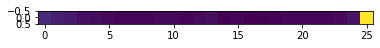

In [83]:
## Function to compute Local Binary Pattern (LBP) 

# source: https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
def LBP(images, numPoints, radius, eps=1e-7):
    # compute the Local Binary Pattern representation
    # of the image, and then use the LBP representation
    # to build the histogram of patterns
    features = []
    for count,image in enumerate(images):
        if image.shape[1] != 0:
          gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
          lbp = feature.local_binary_pattern(gray, numPoints,
              radius, method="uniform")
          (hist, _) = np.histogram(lbp.ravel(),
              bins=np.arange(0, numPoints + 3),
              range=(0, numPoints + 2))

          # normalize the histogram
          hist = hist.astype("float")
          hist /= (hist.sum() + eps)

          # return the histogram of Local Binary Patterns
          features.append(hist)
    return features
negative_patches_LBP = LBP(images=np.array(negative_patches), numPoints=24, radius=8)
positive_patches_LBP = LBP(images=np.array(positive_patches), numPoints=24, radius=8)

plt.imshow(positive_patches_LBP[0].reshape(1, -1))
plt.show()



In [84]:
x = []
y = []

for p in positive_patches_LBP:
  x.append(p)
  y.append(1)

for n in negative_patches_LBP:
  x.append(n)
  y.append(-1)

x = np.array(x)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(913, 26) (913,)
(305, 26) (305,)


In [85]:
cvxopt.solvers.options['show_progress'] = False

class mySVM():
	def __init__(self,kernel="rbf",polyconst=1,gamma=10,degree=2):
		self.kernel = kernel
		self.polyconst = float(1)
		self.gamma = float(gamma)
		self.degree = degree
		self._support_vectors = None
		self._alphas = None
		self.intercept = None
		self._n_support = None
		self.weights = None
		self._support_labels = None
		self._indices = None

	def rbf(self,x,y):
		return np.exp(-1.0*self.gamma*np.dot(np.subtract(x,y).T,np.subtract(x,y)))

	def transform(self,X):
		K = np.zeros([X.shape[0],X.shape[0]])
		for i in range(X.shape[0]):
			for j in range(X.shape[0]):
				K[i,j] = self.rbf(X[i],X[j])
		return K

	def fit(self,data,labels):
		num_data, num_features = data.shape
		labels = labels.astype(np.double)
		K = self.transform(data)
		P = cvxopt.matrix(np.outer(labels,labels)*K)
		q = cvxopt.matrix(np.ones(num_data)*-1)
		A = cvxopt.matrix(labels,(1,num_data))
		b = cvxopt.matrix(0.0)
		G = cvxopt.matrix(np.diag(np.ones(num_data) * -1))
		h = cvxopt.matrix(np.zeros(num_data))

		alphas = np.ravel(cvxopt.solvers.qp(P, q, G, h, A, b)['x'])
		is_sv = alphas>1e-5
		self._support_vectors = data[is_sv]
		self._n_support = np.sum(is_sv)
		self._alphas = alphas[is_sv]
		self._support_labels = labels[is_sv]
		self._indices = np.arange(num_data)[is_sv]
		self.intercept = 0
		for i in range(self._alphas.shape[0]):
			self.intercept += self._support_labels[i] 
			self.intercept -= np.sum(self._alphas*self._support_labels*K[self._indices[i],is_sv])
		self.intercept /= self._alphas.shape[0]

	def predict(self,X):
		if self.kernel=="linear":
			score = np.dot(X,self.weights)+self.intercept
		else:
			score = np.zeros(X.shape[0])
			for i in range(X.shape[0]):
				s = 0
				for alpha,label,sv in zip(self._alphas,self._support_labels,self._support_vectors):
					s += alpha*label*self.rbf(X[i],sv)
				score[i] = s
			score = score + self.intercept
		return np.where(score>0,1,-1)

In [90]:
from sklearn.svm import SVC

model = mySVM(kernel="poly")
model.fit(X_train, y_train)


svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [91]:
prediction = model.predict(X_test)
prediction2 = svclassifier.predict(X_test)

correct1 = 0
correct2 = 0
for i in range(len(list(y_test))):
  if y_test[i] == prediction[i]:
    correct1 += 1
  if y_test[i] == prediction2[i]:
    correct2 += 1


print(correct1/len(list(y_test)))
print(correct2/len(list(y_test)))

0.7573770491803279
0.7704918032786885


(480, 640, 3)


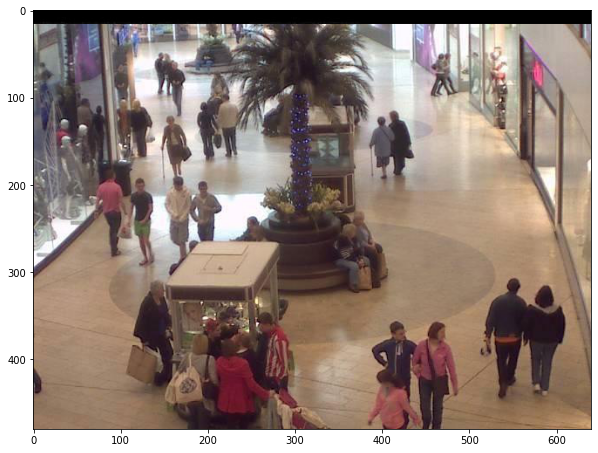

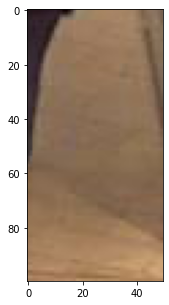

Detected 296 windows.


In [106]:
#sliding window along one frame
input_path = os.path.join(path_frames, image_path)
image = plt.imread(input_path)
print(image.shape)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()
windows = []
our_boxes = []
#sliding window, window size grows as we go down
for a in range(0,621,20):
  for b in range(0,101,50):
    temp_image = image[b:b+50,a:a+20]
    windows.append(temp_image)
    our_boxes.append([b, a, 50, 20])
for a in range(0,601,40):
  for b in range(100,301,50):
    temp_image = image[b:b+90,a:a+40]
    windows.append(temp_image)
    our_boxes.append([b, a, 90, 40])
for a in range(0,591,10):
  for b in range(300,381,80):
    temp_image = image[b:b+100,a:a+50]
    windows.append(temp_image)
    our_boxes.append([b, a, 100, 50])



plt.figure(figsize=(5, 5))
plt.imshow(windows[-1])
plt.show()


print('Detected ' + str(len(windows)) + ' windows.')

In [107]:
np_windows = np.array(windows)
print(np_windows.shape)
print("getting features")
test_windows = LBP(images=np_windows, numPoints=24, radius=8)
print("making predictions")
predictions = model.predict(np.array(test_windows))
#put in seperate block so you don't rerun the last block
pos_windows = []
our_pos_boxes = []
for i in range(len(predictions)):
  if (predictions[i] == 1):
    pos_windows.append(np_windows[i])
    our_pos_boxes.append(our_boxes[i])
np_pos_windows = np.array(pos_windows)
print(np_pos_windows.shape)

'''
for im in np_pos_windows:
  plt.imshow(im)
  plt.show()
'''

(296,)
getting features
making predictions
(117,)


'\nfor im in np_pos_windows:\n  plt.imshow(im)\n  plt.show()\n'

In [118]:

delete = []
for f in range(np_pos_windows.shape[0]):
    delete.append(1)
for a in range(np_pos_windows.shape[0]):
  if (delete[a] == 1):
    hsv1 = cv2.cvtColor(np_pos_windows[a], cv2.COLOR_BGR2HSV)
    hist1 = cv2.calcHist([hsv1], [0,1], None, [180,256], [0,180,0,256])
    cv2.normalize(hist1, hist1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    for b in range(np_pos_windows.shape[0]):
      if (delete[b]==1):
        hsv2 = cv2.cvtColor(np_pos_windows[b], cv2.COLOR_BGR2HSV)
        hist2 = cv2.calcHist([hsv2], [0,1], None, [180,256], [0,180,0,256])
        cv2.normalize(hist2, hist2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        difference = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
        #print(difference)
        if (difference > 0.30 and b != a):
          delete[b] = 0
print(delete)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


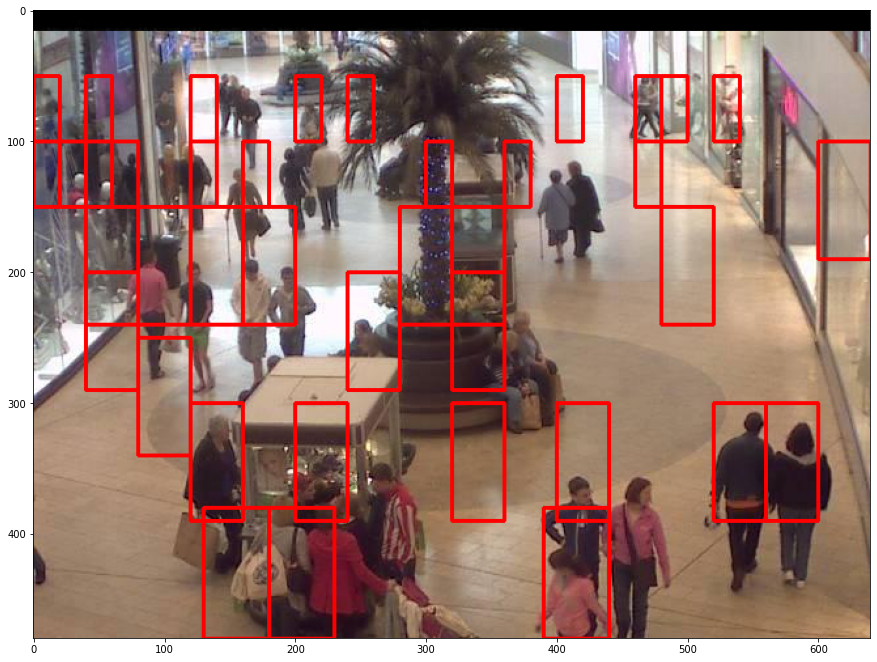

39


In [119]:
im = image.copy()
count = 0
for i in range(len(np_pos_windows)):
  if (delete[i] != 0):
    # draw selected boxes in the original image
    cv2.rectangle(im, (round(our_pos_boxes[i][1]),round(our_pos_boxes[i][0])), (round(our_pos_boxes[i][1]+our_pos_boxes[i][3]),round(our_pos_boxes[i][0]+our_pos_boxes[i][2])), (255, 0, 0), 2)
    count += 1


    
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show()

print(count)

## Todo:
- Fix bug that happens if we extract from more than 9 images
- Decide which feature to use between HoG, Haar, LBP, or other
- Modify SVM code we got to make it less sus
- Tune parameters of SVM to improve results
- Duplicate elimination
- Test it